<a href="https://colab.research.google.com/github/tatsath/PortfolioOptimization/blob/main/BareBonesAnalysis/Step2-Adding%20time%20dimension.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


In [59]:
import numpy as np

import seaborn as sns
import numpy.matlib


import matplotlib.pyplot as plt
from matplotlib import cm

from scipy import stats
from scipy.stats import norm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import time

import copy



In [60]:
#Setting seed
torch.manual_seed(123)
torch.cuda.manual_seed(123)
np.random.seed(0)

In [61]:
# 1 asset 
params = {
    "S0" : np.array([1]),
    "mu" : np.array([0.03]),
    "sigma" : np.array([.2]),
    "rho" : np.array([[1]]),
    "rf" : 0.00,
    "delta" : np.array([0.7])
    }
params_Q = copy.copy(params)
params_Q["mu"] = np.array([params_Q["rf"]])


# ## 2 assets 
# params = {
#     "S0" : np.array([1, 2]),
#     "mu" : np.array([0.05, 0.06]),
#     "sigma" : np.array([0.1, 0.12]),
#     "rho" : np.array([[1, .25],[.25,1]]),
#     "rf" : 0.00,
#     "delta" : np.array([0.25, 0.75])
#     }
# params_Q = copy.copy(params)
# params_Q["mu"] = np.array([params_Q["rf"],params_Q["rf"]])

## 4 assets 
# params = {
#     "S0" : np.array([1, 2,3,1]),
#     "mu" : np.array([0.5, 0.06, .06, .06]),
#     "sigma" : np.array([.7, 0.10 , .10, .10]),
#     "rho" : np.array([[1, 0.25,.25, .25],[0.25,1,.25, .25], [0.25,.25,1, .25], [0.25,.25,.25,1]]),
#     "rf" : 0.01,
#     "delta" : np.array([0.2, 0.3, .3, .4 ])
#     }
#params_Q = copy.copy(params)
#params_Q["mu"] = np.array([params_Q["rf"], params_Q["rf"], params_Q["rf"], params_Q["rf"]])

print(params)

print(params_Q)

{'S0': array([1]), 'mu': array([0.03]), 'sigma': array([0.2]), 'rho': array([[1]]), 'rf': 0.0, 'delta': array([0.7])}
{'S0': array([1]), 'mu': array([0.]), 'sigma': array([0.2]), 'rho': array([[1]]), 'rf': 0.0, 'delta': array([0.7])}


In [62]:
#%% Simulation Engine for price paths
def SimPath(Ndt, params, T, Nsims):
    
    dt = T/Ndt
    
    N_assets= params["mu"].shape[0]
    
    assert N_assets == params["sigma"].shape[0], "#assets in mu != #assets in sigma"
    assert N_assets == params["rho"].shape[0], "#assets in mu != #assets in rho"
    assert params["rho"].ndim == 2, "rho must be matrix"
    assert N_assets == params["rho"].shape[1], "rho not square matrix"
    
    S = np.zeros((Ndt+1, Nsims, N_assets ))
    S[0,:,:] = params["S0"]

    
    for i in range(Ndt):
        
        dW = np.sqrt(dt) * np.random.multivariate_normal(np.zeros(N_assets), params["rho"], Nsims)
        S[i+1,:,:] = S[i,:,:] * np.exp((params["mu"]-0.5*params["sigma"]**2)*dt + params["sigma"]*dW)
        
    t = np.linspace(0,T,Ndt+1)
    return t, S
        

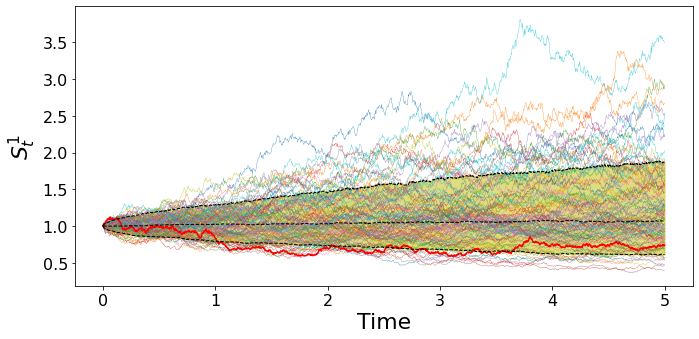

In [63]:
# Sim some paths and show sims with quantiles and a sample path
t, S = SimPath(Ndt=252*5, params = params, T=5, Nsims = 1000)

plt.figure(figsize=(10,5))
plt.rcParams.update({'font.size': 16})
plt.rc('axes', labelsize=22)
for i in range(S.shape[2]):
    
    plt.subplot(1,S.shape[2],i+1)
    
    plt.fill_between(t, np.quantile(S[:,:,i],0.1,axis=1).T, np.quantile(S[:,:,i],0.9,axis=1).T, color='y', alpha=0.5)
    plt.plot(t, S[:,:100,i],linewidth=0.3)
    plt.plot(t, S[:,0,i],color='r',linewidth=1.5)
    plt.plot(t, np.quantile(S[:,:,i],[0.1, 0.5, 0.9],axis=1).T,color='k',linewidth=1, linestyle='--')
    
    plt.xlabel("Time")
    plt.ylabel("$S_t^" +str(i+1)+"$")
    
plt.tight_layout()
plt.show()

In [64]:
S.shape

(1261, 1000, 1)

In [65]:
# the ANN for policy iteration
class MyNet(nn.Module):
    
    def __init__(self, n, n_assets ):
        super(MyNet, self).__init__()

        # 2 input layer (t, X_t^delta), 1 output channel, 3 hidden layers with n units each
        self.f_in_to_h1 = nn.Linear( 2 , n)
        self.f_h1_to_h2 = nn.Linear(n, n)
        self.f_h2_to_out = nn.Linear(n, n_assets)
        self.myReLU = nn.ReLU()

    def forward(self, x):
        
        # input into 1st hidden layer
        h1 = self.myReLU(self.f_in_to_h1(x) )
        
        # 1st hidden to 2nd hidden layer
        h2 = self.myReLU(self.f_h1_to_h2(h1))
            
        # 2nd hidden layer to output layer
        y = self.f_h2_to_out(h2)      
        #y = y.clamp(-1,1)
        #y = F.logsigmoid(h2)
        
        return y

In [66]:
# from a minibatch compute the risk measure
def GetRiskMeasure(X, Type):
    #TVaR    
    if (Type == "TVaR"):
        
        alpha = 0.15
        Qtl= torch.quantile(X, alpha)
        RiskMeasure = -torch.mean(X[X<=Qtl])
    
    # alpha-beta
    elif (Type == "alpha-beta" ):
        
        alpha = 0.1
        LQtl = torch.quantile(X,alpha)
        
        beta = 0.9
        UQtl = torch.quantile(X,beta)
        
        # weight factor (p in the paper)
        p = 0.75
        eta = p * alpha + (1-p) * (1-beta)
        RiskMeasure = -(p* alpha* torch.mean(X[X<=LQtl]) \
                        + (1-p) * (1-beta)* torch.mean(X[X>=UQtl] ) )/eta
        
        
    #Variance
    elif (Type == "Variance"):  
        RiskMeasure = torch.var(X)   
        
    return RiskMeasure

In [67]:
# from a minibatch compute the Wasserstein Distance
def getWassDistance(X, Y):
    
    # generate co-monotonic versions of the sample
    X_sorted, _ = torch.sort(X)
    Y_sorted, _ = torch.sort(Y)
    
    wass_dist = torch.sqrt(torch.mean(( X_sorted - Y_sorted )**2))
    
    return wass_dist 

In [68]:
   
# t, S = SimPath(500, params, T=5, Nsims=200)  
# S_t = torch.tensor(S, dtype=torch.float, requires_grad=False, device=device)
# S_t.shape

In [69]:

# x=np.zeros((Ndt+1, Nsims, 2))   
# #set_trace()

# x[:,:,0] = np.matlib.repmat(t.reshape(-1,1)/t[-1], 1, Nsims)
# xt = torch.tensor(x, dtype=torch.float, device=device)

# xt[:,:,1] = S_t[:,:,0]/X0

In [70]:
# given an ANN run a simulation and compute the riskmeasure
from IPython.core.debugger import set_trace

def SimRM(net, Ndt, T, Nsims, params, device):
      
    t, S = SimPath(Ndt, params, T=T, Nsims=Nsims)  
    #set_trace()
    # initial investment amount
    X0 = 1
    
    num_asset = S.shape[2]
    dt = t[1]-t[0]
    
    # don't think we need sensitivities w.r.t. this as they are fixed per simulation
    S_t = torch.tensor(S, dtype=torch.float, requires_grad=False, device=device)

    x=np.zeros((Ndt+1, Nsims, 2))   
    #set_trace()
    
    x[:,:,0] = np.matlib.repmat(t.reshape(-1,1)/t[-1], 1, Nsims)
    xt = torch.tensor(x, dtype=torch.float, device=device)
    
    xt[:,:,1] = S_t[:,:,0]/X0

    wt = net(xt) 
    
    S_Ret = (S_t[1:,:,:]-S_t[:-1,:,:])/S_t[:-1,:,:]
    
    #Benchmark Delta and return
    Delta_t = torch.zeros((Ndt, Nsims, num_asset), \
                                 dtype=torch.float, requires_grad=False, device=device)
    # note only 90% invested in risky assets here... 10% in risk-free
    delta = torch.tensor(params["delta"],requires_grad=False, device=device)
    delta_r = 1 - torch.sum(delta)
    Delta_t += delta 

    # accumulate returns as we go along
    Benchmark_Ret = delta_r * params["rf"] * dt+ torch.sum(Delta_t * S_Ret , axis=2)
    
    BenchmarkVal_path = torch.zeros((Ndt+1,Nsims), dtype=torch.float, requires_grad=False, device=device)
    BenchmarkVal_path[0,:]  = X0
    BenchmarkVal_path[1:,:] = X0*torch.cumprod( (1.0+Benchmark_Ret), axis=0)
    BenchmarkVal_T = BenchmarkVal_path[-1,:].reshape(-1,1)
    #print(torch.mean(BenchmarkVal_path,1))
    #
    # Getting the portfolio weights using benchmark value and time as features
    #     
   
    
    # the candidate portolio
    Portfolio_Ret = (1-torch.sum(wt[:-1,:,:], axis=2)) * params["rf"] * dt+ torch.sum(wt[:-1,:,:] * S_Ret , axis=2)
    
    PortfolioVal_path = torch.zeros((Ndt+1,Nsims), dtype=torch.float, requires_grad=False, device=device)    
    PortfolioVal_path[0,:] = X0
    PortfolioVal_path[1:,:] = X0*torch.cumprod( (1.0+Portfolio_Ret), axis=0)
    PortfolioVal_T = PortfolioVal_path[-1,:].reshape(-1,1)
        
    
    # Compute the risk measure and wasstertein Distance for the computation
    wass_dist = getWassDistance(PortfolioVal_T, BenchmarkVal_T)
    RiskMeasure = GetRiskMeasure(PortfolioVal_T, "alpha-beta") 
    
    return wt, RiskMeasure, wass_dist, PortfolioVal_T, BenchmarkVal_T, t, BenchmarkVal_path.cpu().detach().numpy(), PortfolioVal_path.cpu().detach().numpy()

In [71]:
# plot histogram of portfolio, sample path, and show dependence of X^\pi on X^\delta
def PlotHists(X, Y, t, X_path, Y_path):
    
    Xcp = X.clone().cpu().detach().numpy()
    Ycp = Y.clone().cpu().detach().numpy()
    
    plt.figure(figsize=(15,5))
    
    plt.subplot(1,3,1)
    bins = np.linspace(0,4,50)
    
    sns.distplot(Xcp, hist=True, kde=True,  bins=bins, label='Benchmark')
    sns.distplot(Ycp,  hist=True, kde=True, bins=bins, label='Portfolio')  
    
    plt.axvline(np.quantile(Xcp, 0.05),color='k',linewidth=0.5)
    plt.axvline(np.quantile(Ycp, 0.05),color='r',linewidth=0.5)
    
    plt.legend()
    plt.xlim(0,4)
    

    plt.subplot(1,3,2)
    plt.fill_between(t, np.quantile(X_path,0.1,axis=1).T, np.quantile(X_path,0.9,axis=1).T, color='y', alpha=0.5)
    plt.fill_between(t, np.quantile(Y_path,0.1,axis=1).T, np.quantile(Y_path,0.9,axis=1).T, color='g', alpha=0.5)
    plt.plot(t,X_path[:,0], label='Benchmark', color='r')
    plt.plot(t,np.quantile(X_path,[0.1,0.5,0.9],axis=1).T, '--y')
    plt.plot(t,Y_path[:,0], label='Portfolio', color='k')
    plt.plot(t,np.quantile(Y_path,[0.1,0.5,0.9],axis=1).T, '--g')
    
    plt.legend()
    
    
    plt.subplot(1,3,3)
    xs = [min(Xcp), max(Xcp)]
    plt.plot(xs,xs,'--k' )
    plt.scatter(Xcp,Ycp, marker='o',color='r', s=5)
    plt.xlim(0,5)
    plt.ylim(0,5)
    
    plt.rcParams.update({'font.size': 16})
    plt.rc('axes', labelsize=22)
    
    plt.tight_layout()
    
    plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


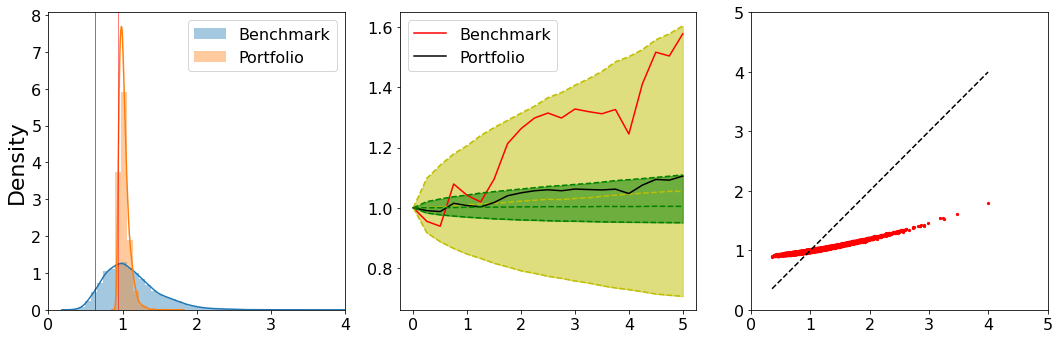

In [72]:
# create an ANN and use GPU if available

if torch.cuda.is_available():
    device = torch.device('cuda') 
else:
    device = torch.device('cpu') 

net = MyNet(50, len(params["S0"])).to(device)

wt, RiskMeasure, wass_dist, PortfolioVal_T, BenchmarkVal_T, \
    t, BenchmarkVal_path, PortfolioVal_path = SimRM(net, Ndt=20, T=5, Nsims=10000, params=params, device=device)
    
PlotHists(BenchmarkVal_T, PortfolioVal_T, t, BenchmarkVal_path, PortfolioVal_path)


In [73]:
PortfolioVal_path.shape

(21, 10000)

In [74]:
torch.cuda.is_available()

True

.....................20 duaration =  0.474  secs
Wass Dist: 0.124 Risk Measure: -1.004 Loss: 11.357


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


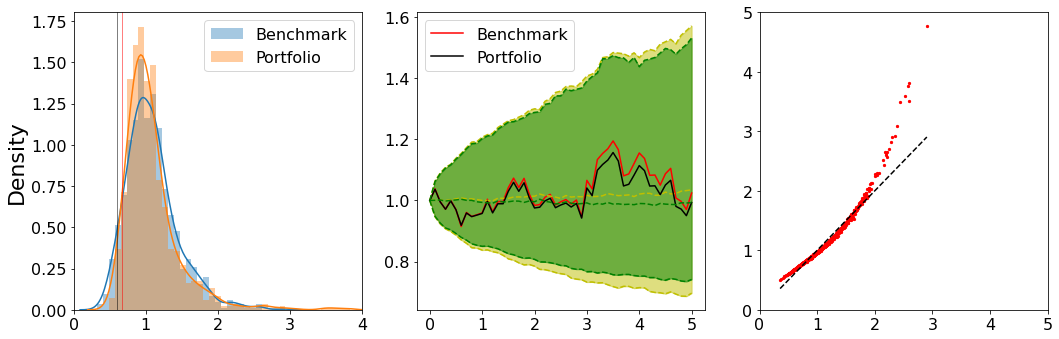

0.9953104 0.99283177

....................40 duaration =  1.231  secs
Wass Dist: 0.092 Risk Measure: -0.992 Loss: -0.992


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


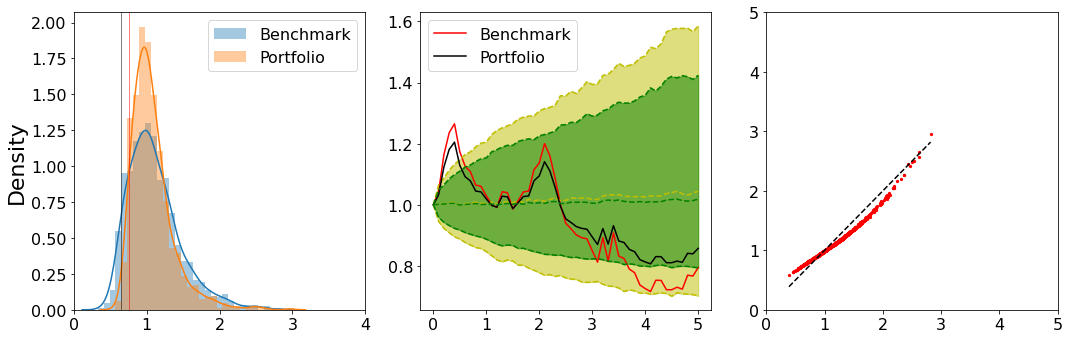

0.9983215 0.9991825

....................60 duaration =  1.343  secs
Wass Dist: 0.086 Risk Measure: -0.986 Loss: -0.986


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


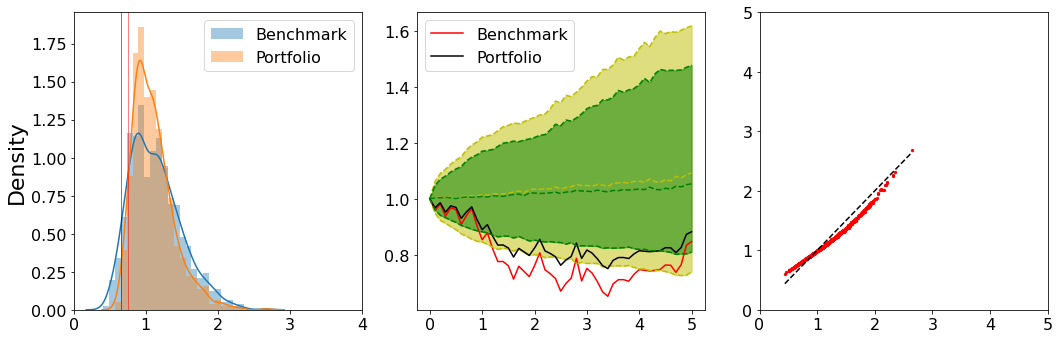

0.98787445 0.98883325

....................80 duaration =  1.263  secs
Wass Dist: 0.084 Risk Measure: -0.975 Loss: -0.975


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


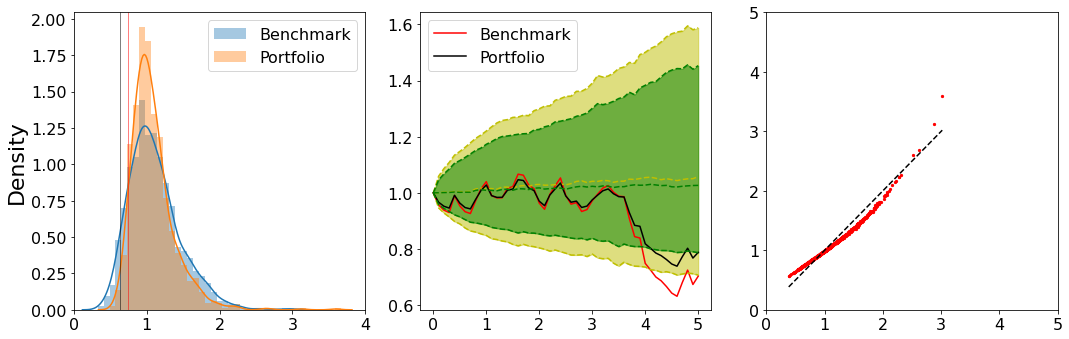

0.99793255 0.9979651

....................100 duaration =  1.240  secs
Wass Dist: 0.083 Risk Measure: -0.989 Loss: -0.989


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


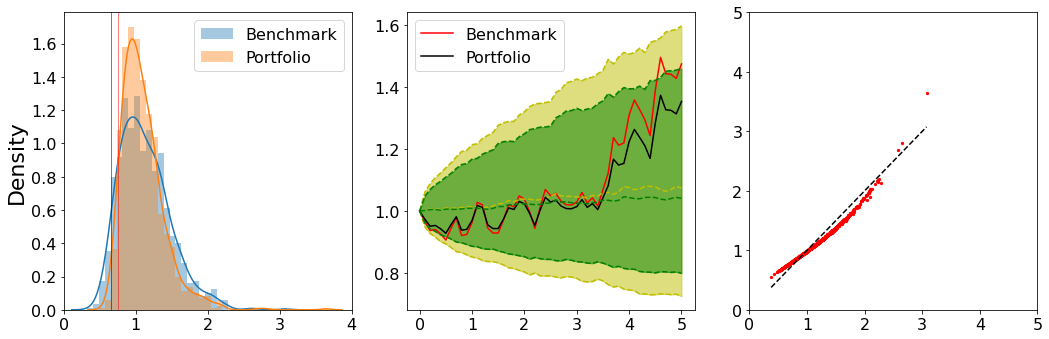

0.9818969 0.9850936

....................120 duaration =  1.348  secs
Wass Dist: 0.075 Risk Measure: -0.974 Loss: -0.974


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


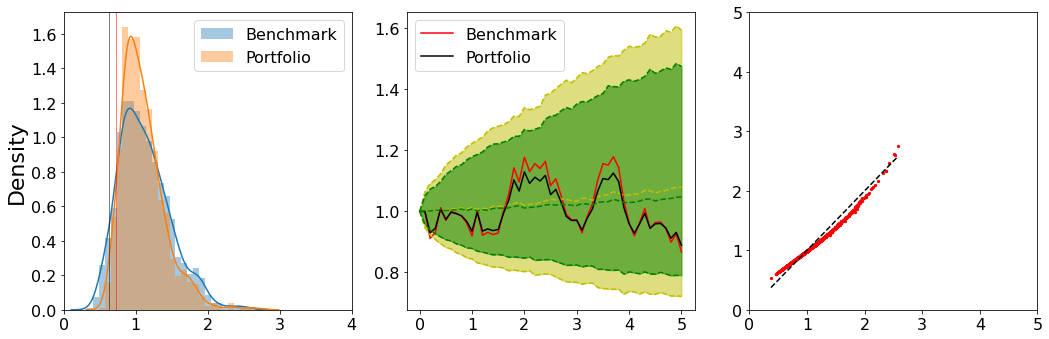

1.0122532 1.0104239

....................140 duaration =  1.236  secs
Wass Dist: 0.071 Risk Measure: -0.965 Loss: -0.965


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


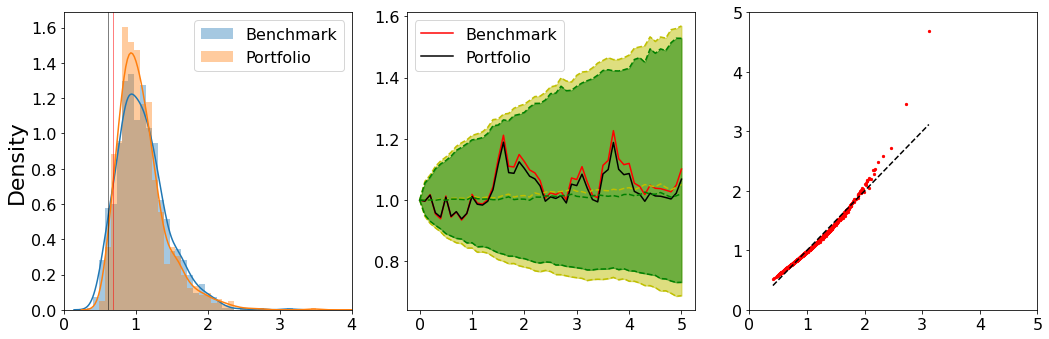

0.99107116 0.9926775

....................160 duaration =  1.191  secs
Wass Dist: 0.065 Risk Measure: -0.980 Loss: -0.980


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


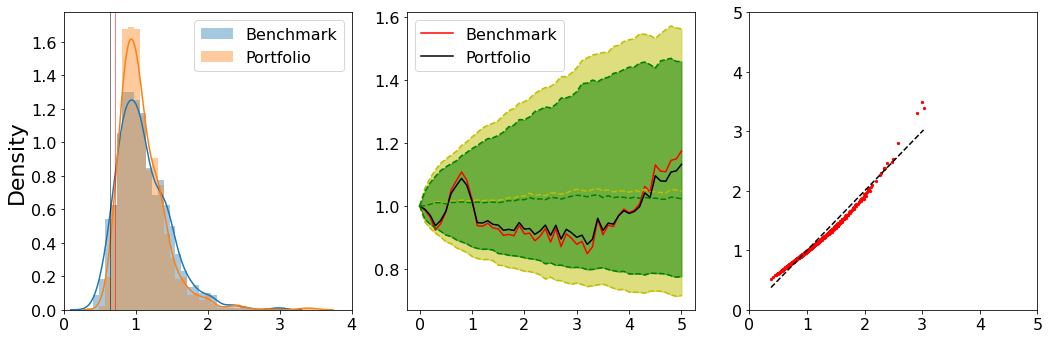

0.98899454 0.9904493

....................180 duaration =  1.210  secs
Wass Dist: 0.073 Risk Measure: -0.969 Loss: -0.969


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


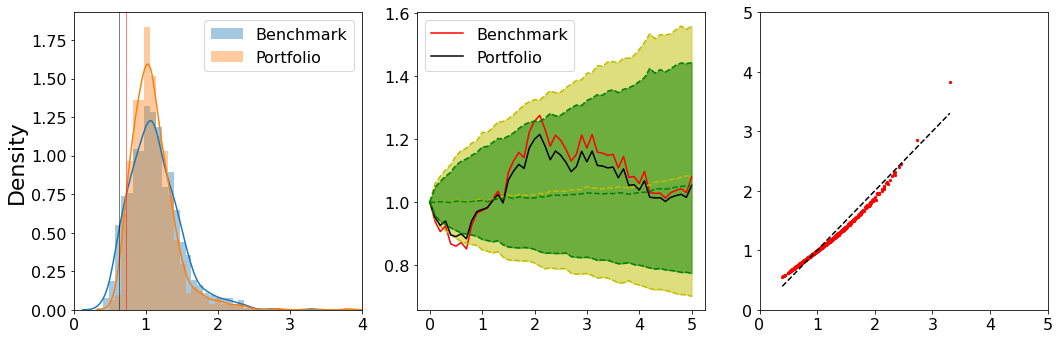

1.0018289 1.0000662

....................200 duaration =  1.286  secs
Wass Dist: 0.072 Risk Measure: -0.961 Loss: -0.961


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


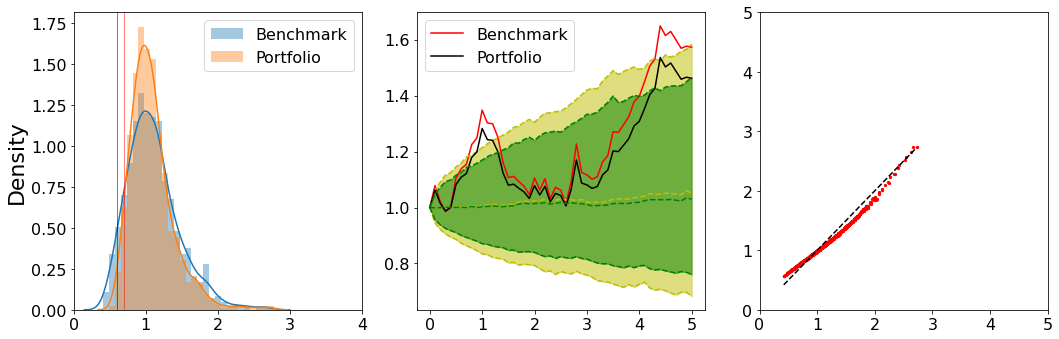

0.97754025 0.98226964

....................220 duaration =  1.265  secs
Wass Dist: 0.070 Risk Measure: -0.975 Loss: -0.975


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


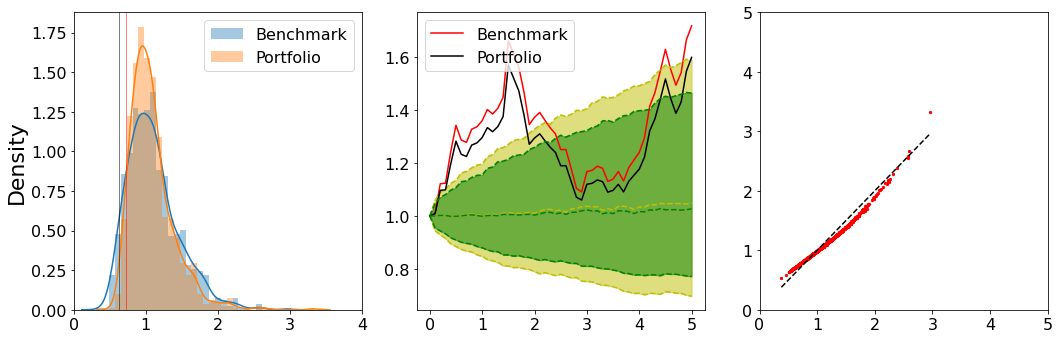

0.99860203 1.0005752

....................240 duaration =  1.268  secs
Wass Dist: 0.079 Risk Measure: -0.966 Loss: -0.966


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


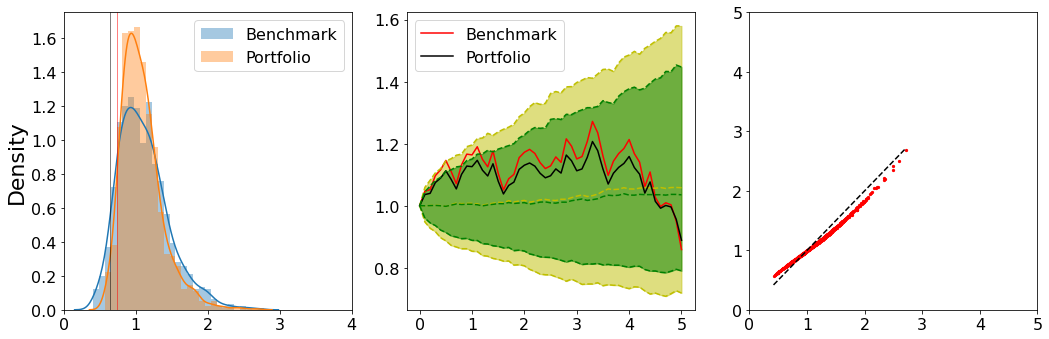

0.9962858 0.9965926

....................260 duaration =  1.186  secs
Wass Dist: 0.078 Risk Measure: -0.954 Loss: -0.954


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


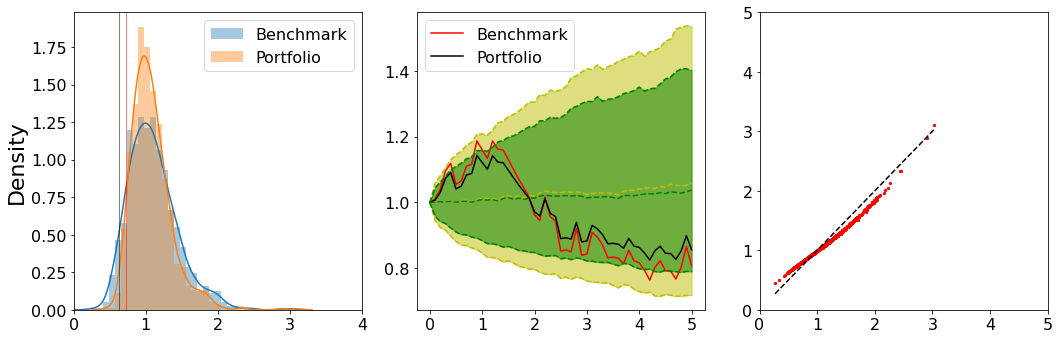

0.9974944 0.9987246

....................280 duaration =  1.324  secs
Wass Dist: 0.079 Risk Measure: -0.972 Loss: -0.972


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


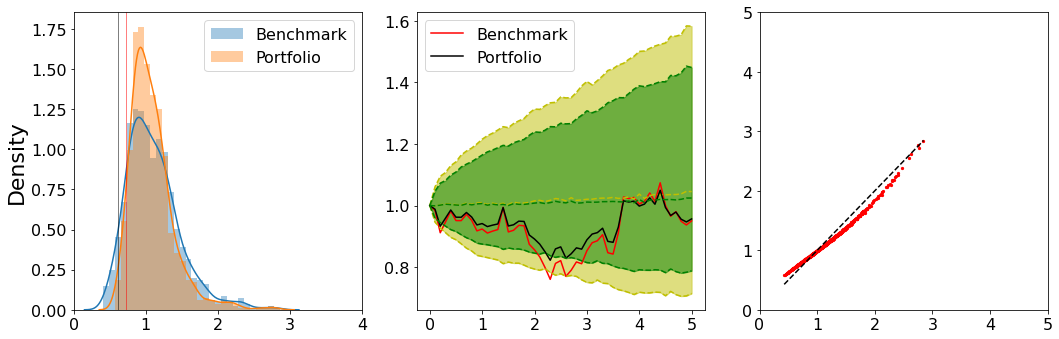

1.0055796 1.0041274

....................300 duaration =  1.282  secs
Wass Dist: 0.081 Risk Measure: -0.980 Loss: -0.980


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


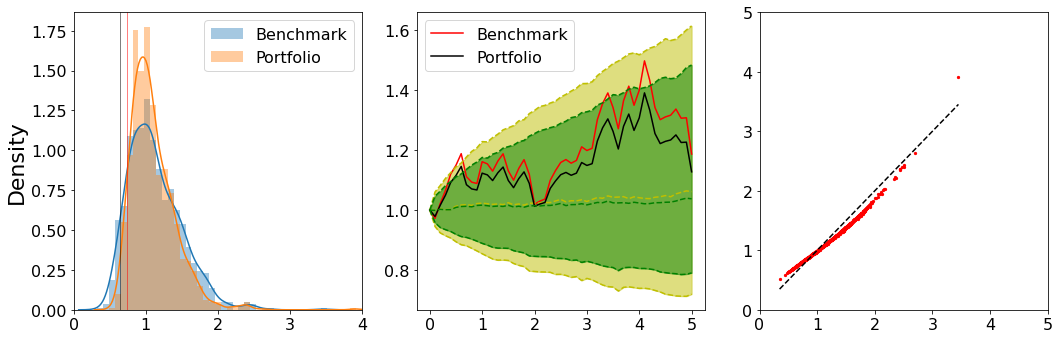

1.0055983 1.0032066

....................320 duaration =  1.233  secs
Wass Dist: 0.076 Risk Measure: -0.947 Loss: -0.947


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


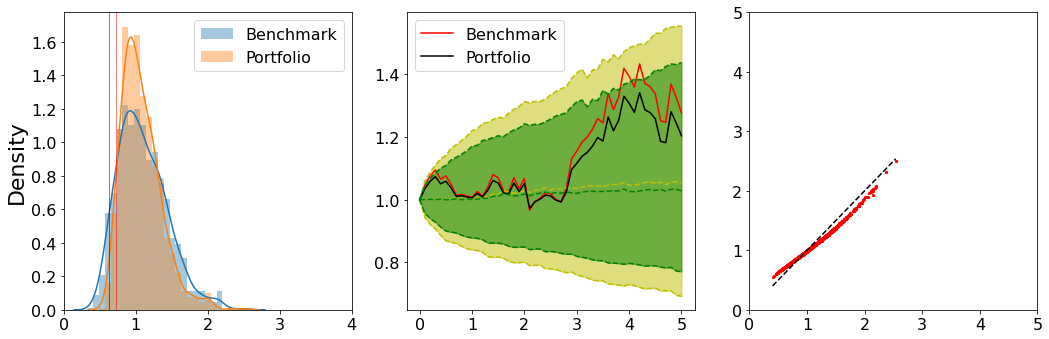

0.98511237 0.98808897

....................340 duaration =  1.340  secs
Wass Dist: 0.074 Risk Measure: -0.948 Loss: -0.948


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


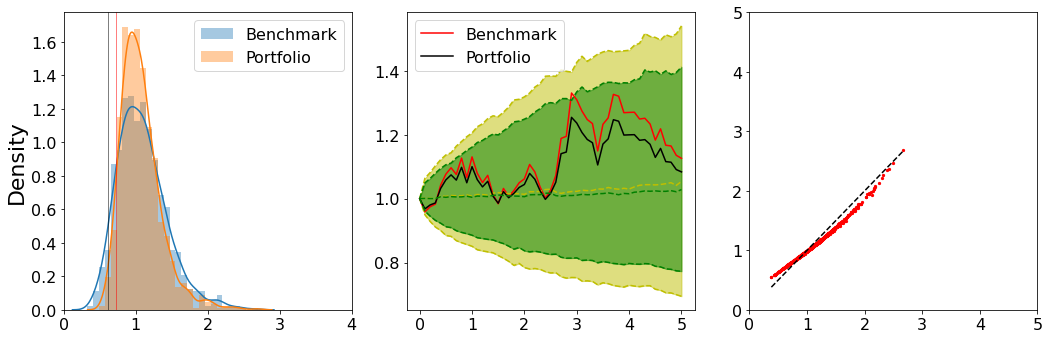

1.0035563 1.0030051

....................360 duaration =  1.317  secs
Wass Dist: 0.074 Risk Measure: -0.959 Loss: -0.959


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


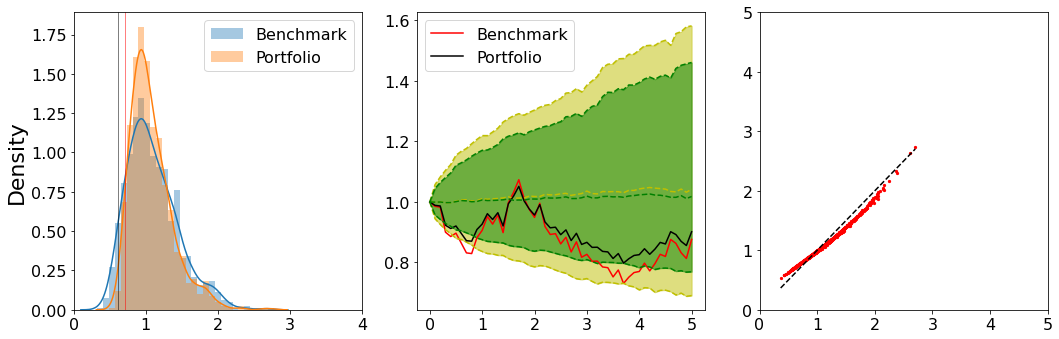

0.997996 0.99686974

....................380 duaration =  1.261  secs
Wass Dist: 0.080 Risk Measure: -0.967 Loss: -0.967


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


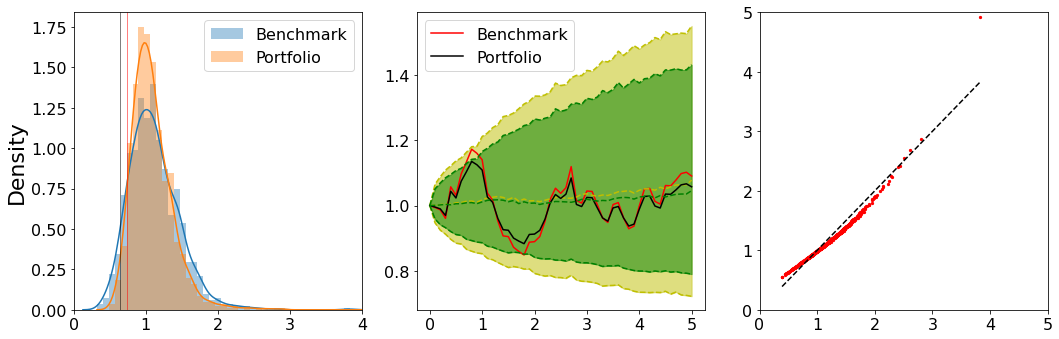

0.99929416 0.9987878

....................400 duaration =  1.290  secs
Wass Dist: 0.070 Risk Measure: -0.946 Loss: -0.946


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


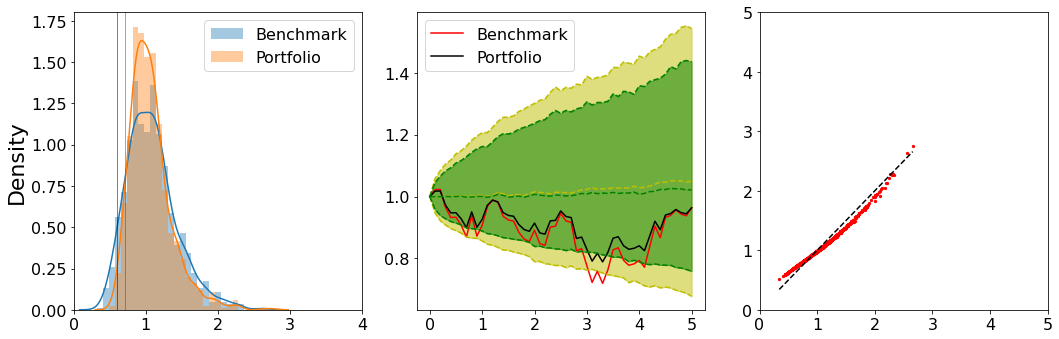

1.0065777 1.0066854

....................420 duaration =  1.372  secs
Wass Dist: 0.069 Risk Measure: -0.966 Loss: -0.966


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


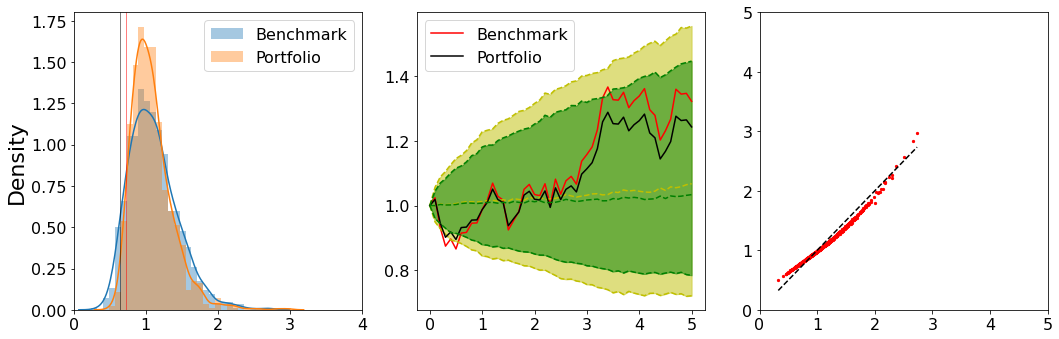

0.99993837 1.0005242

....................440 duaration =  1.371  secs
Wass Dist: 0.071 Risk Measure: -0.976 Loss: -0.976


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


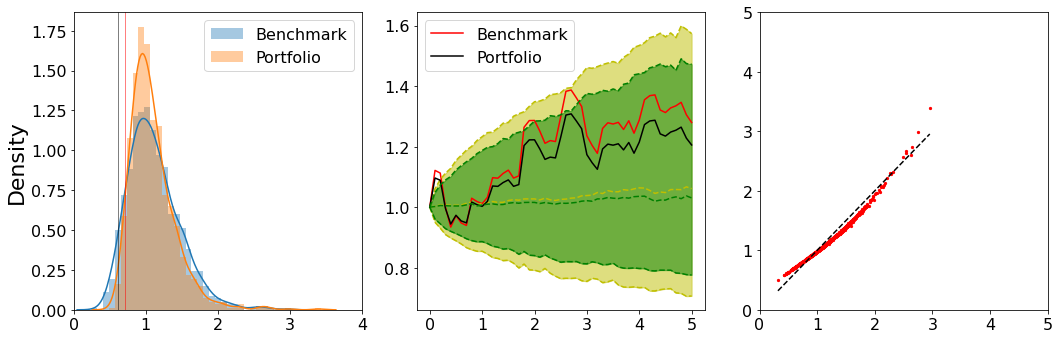

0.9972093 0.99933535

....................460 duaration =  1.289  secs
Wass Dist: 0.065 Risk Measure: -0.977 Loss: -0.977


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


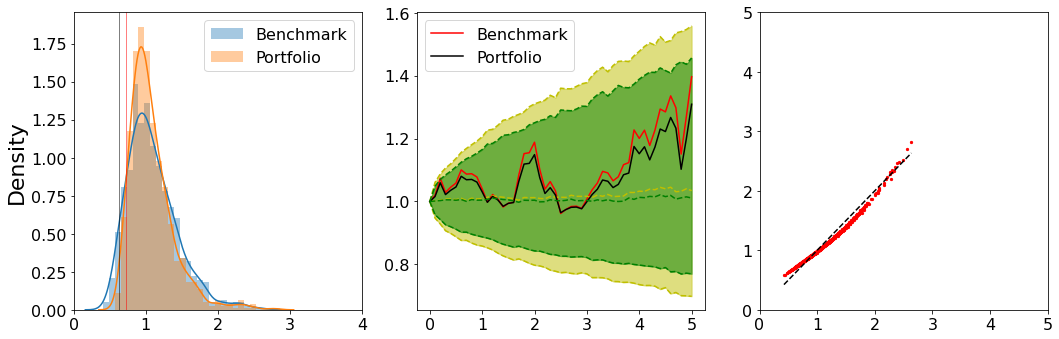

0.9973763 0.9966485

....................480 duaration =  1.301  secs
Wass Dist: 0.069 Risk Measure: -0.977 Loss: -0.977


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


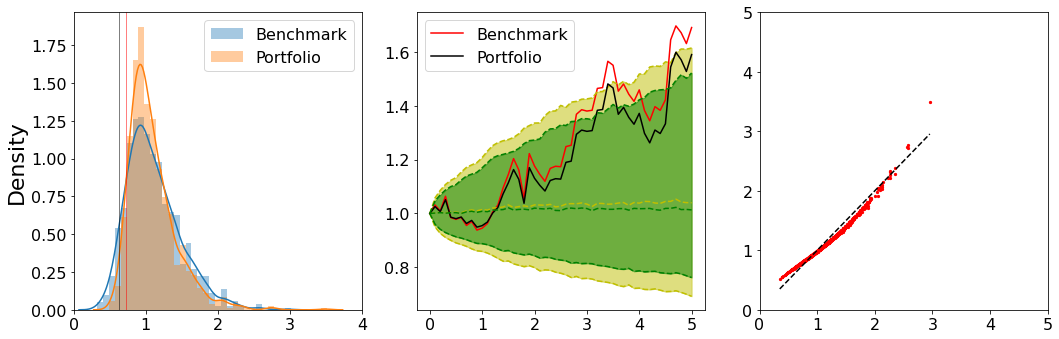

1.0039408 1.0006449

....................500 duaration =  1.360  secs
Wass Dist: 0.067 Risk Measure: -0.978 Loss: -0.978


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


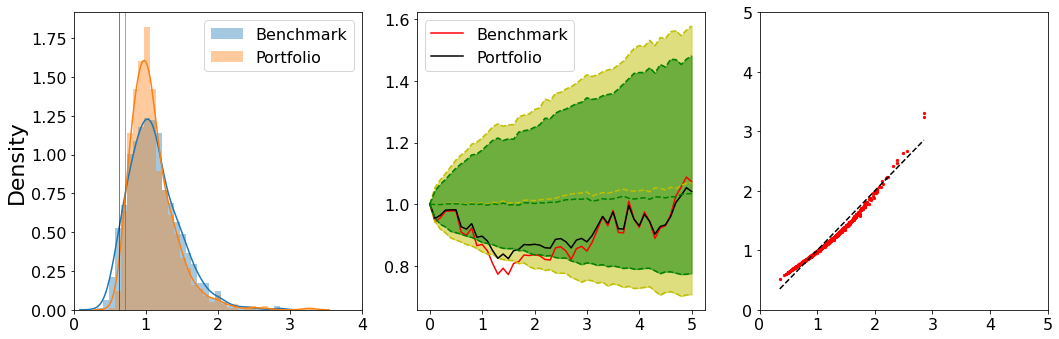

0.9977384 0.9963549

....................520 duaration =  1.221  secs
Wass Dist: 0.065 Risk Measure: -0.961 Loss: -0.961


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


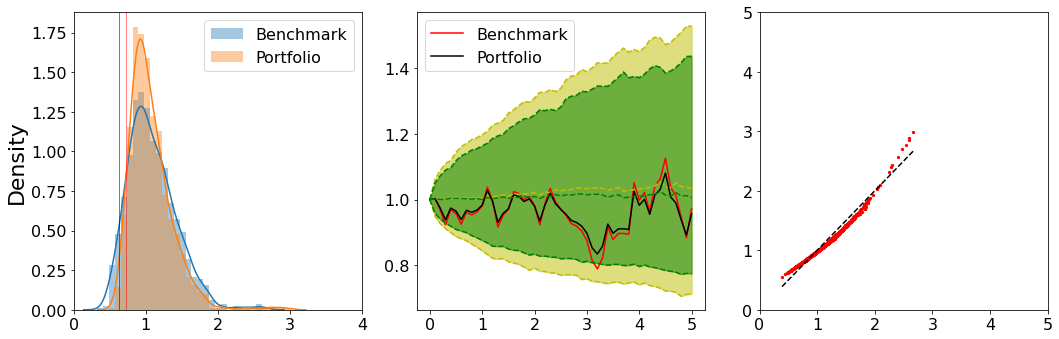

1.0038213 1.003645

....................540 duaration =  1.331  secs
Wass Dist: 0.088 Risk Measure: -0.977 Loss: -0.977


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


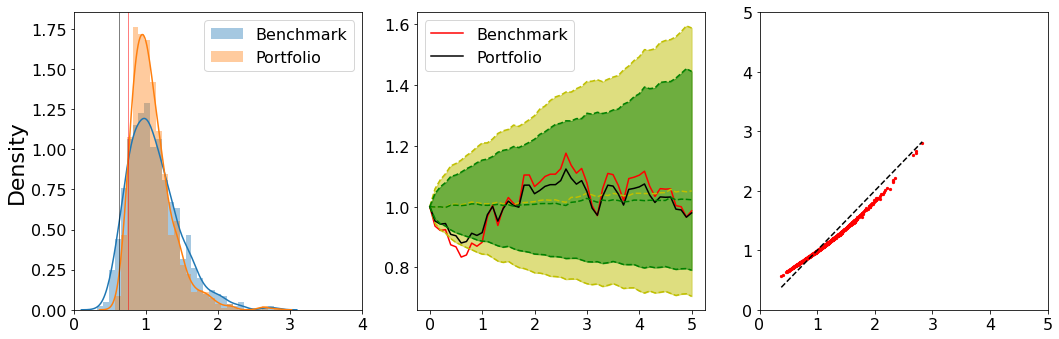

0.9900955 0.99385166

....................560 duaration =  1.359  secs
Wass Dist: 0.063 Risk Measure: -0.968 Loss: -0.968


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


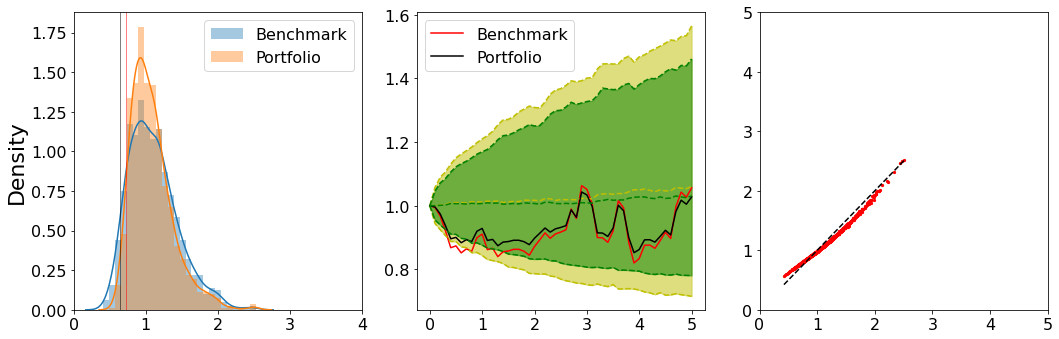

0.9872723 0.9900056

....................580 duaration =  1.278  secs
Wass Dist: 0.079 Risk Measure: -1.008 Loss: -1.008


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


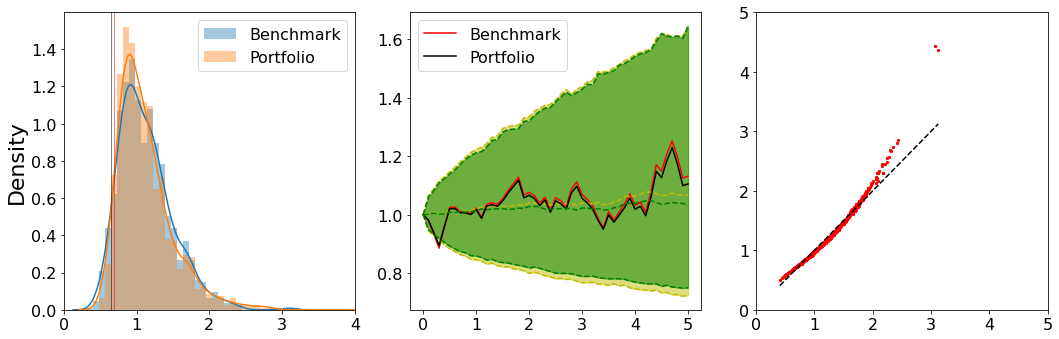

0.9951313 0.9945459

....................600 duaration =  1.244  secs
Wass Dist: 0.037 Risk Measure: -0.967 Loss: -0.967


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


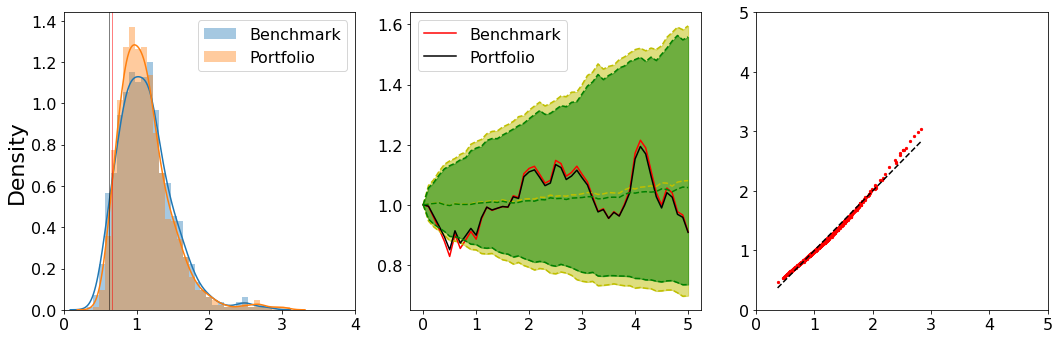

0.9941426 0.9946311

....................620 duaration =  1.255  secs
Wass Dist: 0.031 Risk Measure: -0.982 Loss: -0.982


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


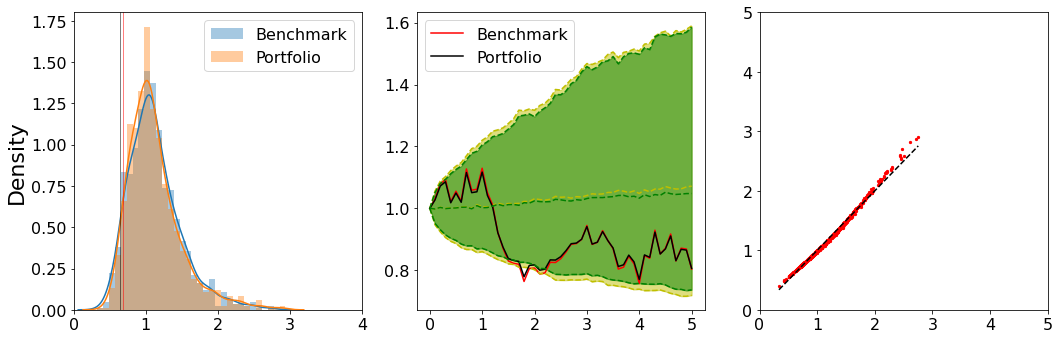

0.9980087 0.99850935

....................640 duaration =  1.393  secs
Wass Dist: 0.073 Risk Measure: -0.946 Loss: -0.946


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


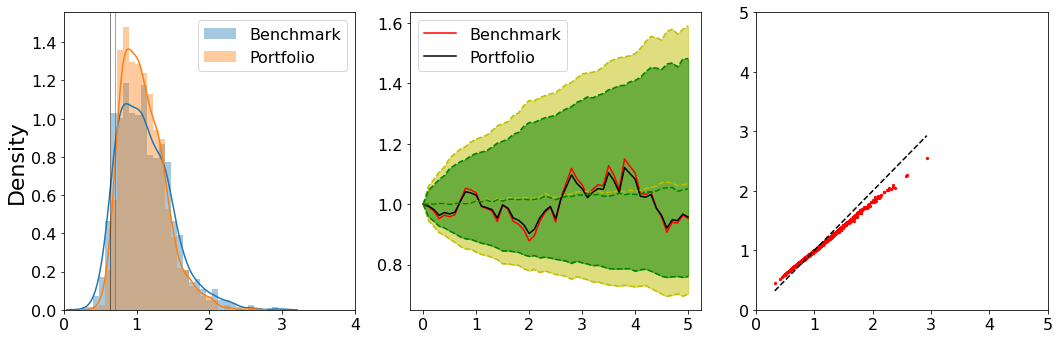

1.0115341 1.0088534

....................660 duaration =  1.245  secs
Wass Dist: 0.028 Risk Measure: -0.952 Loss: -0.952


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


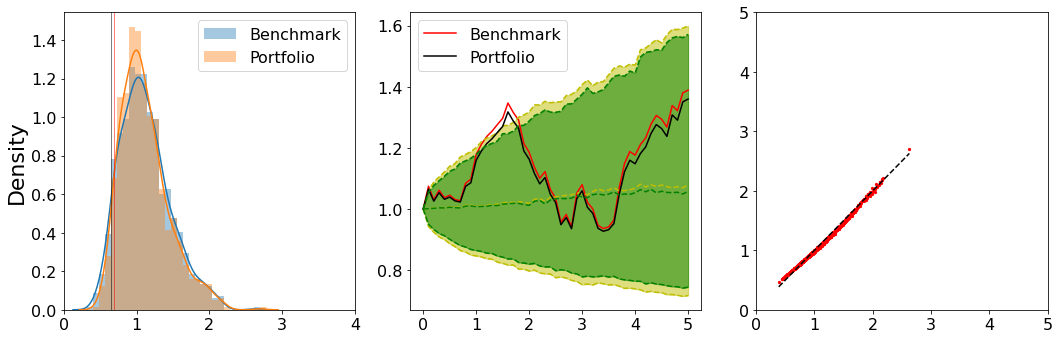

1.004593 1.0045949

....................680 duaration =  1.291  secs
Wass Dist: 0.030 Risk Measure: -0.958 Loss: -0.958


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


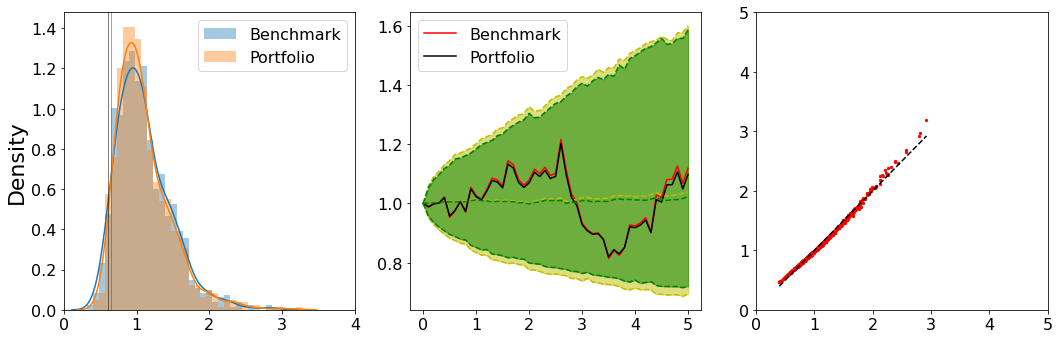

0.9853014 0.98552763

....................700 duaration =  1.344  secs
Wass Dist: 0.033 Risk Measure: -0.959 Loss: -0.959


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


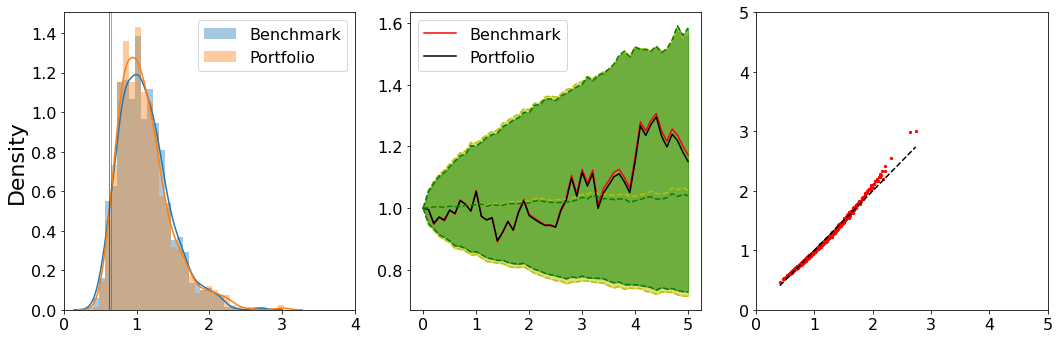

1.0057822 1.0069376

....................720 duaration =  1.394  secs
Wass Dist: 0.101 Risk Measure: -0.949 Loss: 9.180


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


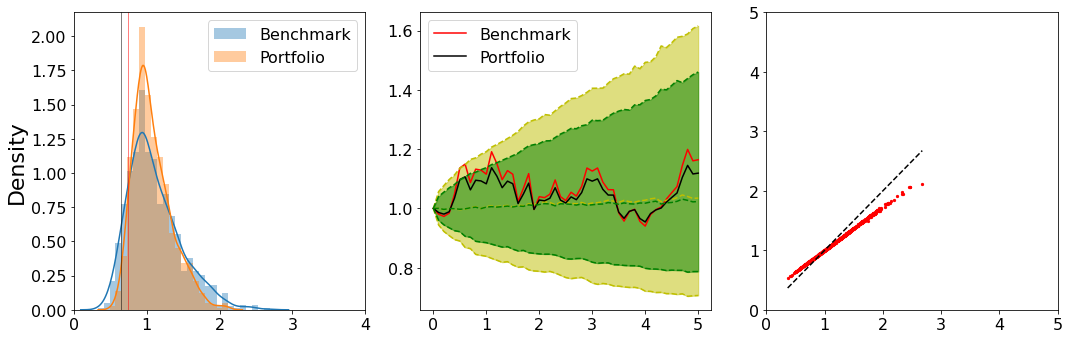

1.0153804 1.0108254

....................740 duaration =  1.316  secs
Wass Dist: 0.039 Risk Measure: -0.954 Loss: -0.954


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


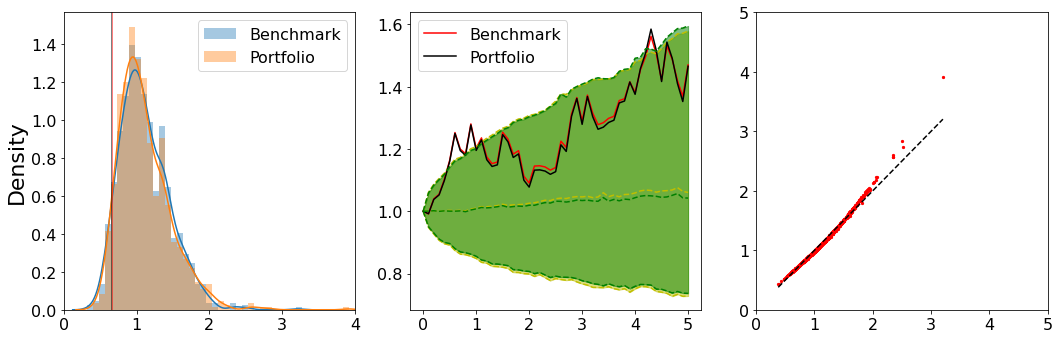

0.98762006 0.9861466

....................760 duaration =  1.290  secs
Wass Dist: 0.064 Risk Measure: -0.977 Loss: -0.977


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


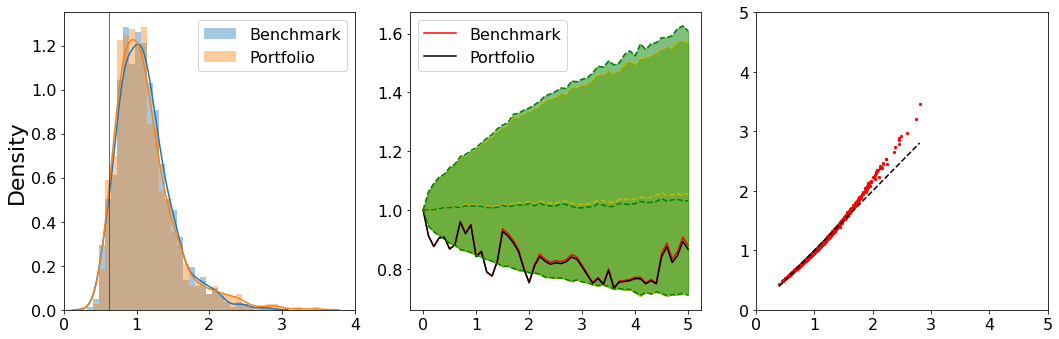

0.9968421 0.9989211

....................780 duaration =  1.390  secs
Wass Dist: 0.072 Risk Measure: -0.987 Loss: -0.987


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


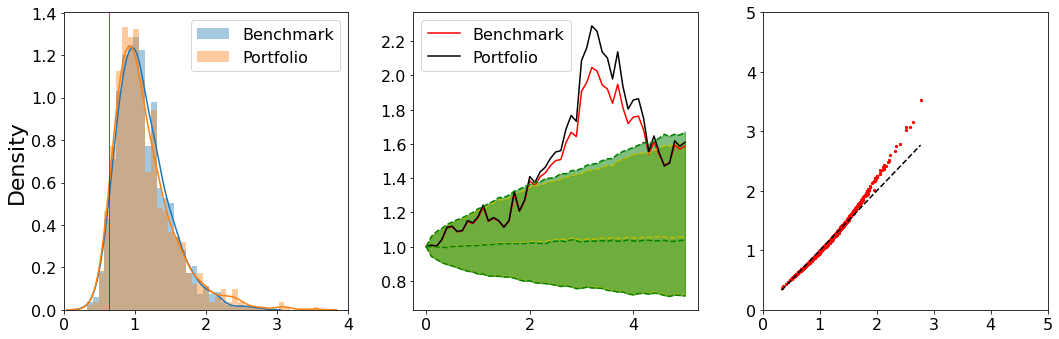

1.0067788 1.0061959

....................800 duaration =  1.397  secs
Wass Dist: 0.075 Risk Measure: -0.967 Loss: -0.967


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


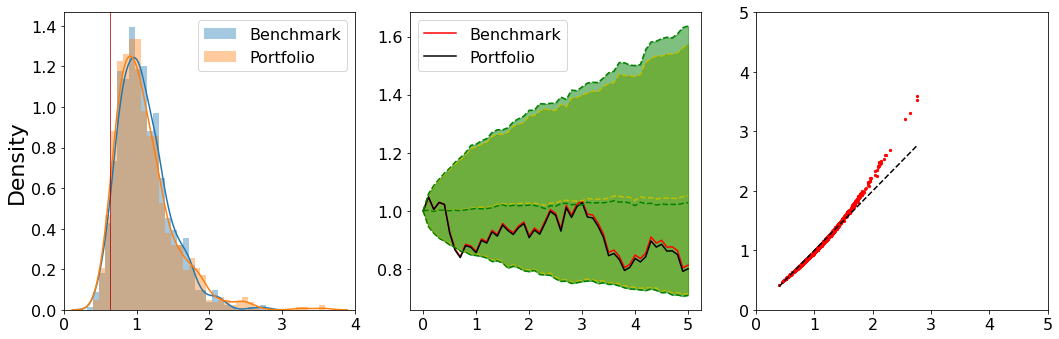

0.98465186 0.9824009

....................820 duaration =  1.330  secs
Wass Dist: 0.087 Risk Measure: -0.995 Loss: -0.995


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


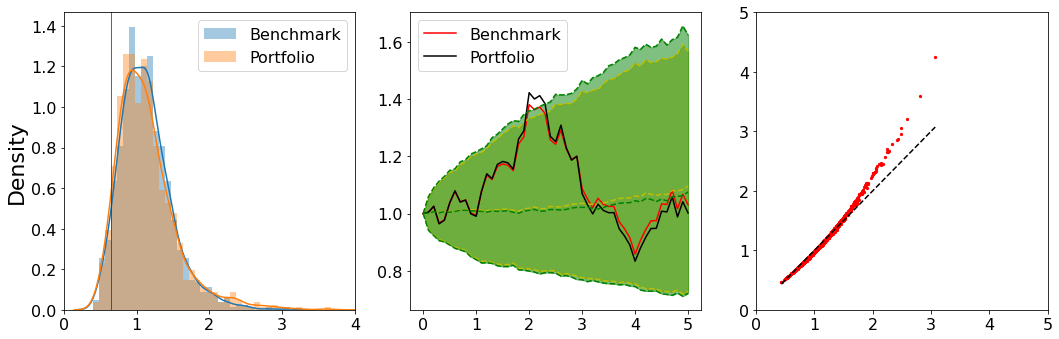

0.9949336 0.9943509

....................840 duaration =  1.371  secs
Wass Dist: 0.059 Risk Measure: -0.939 Loss: -0.939


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


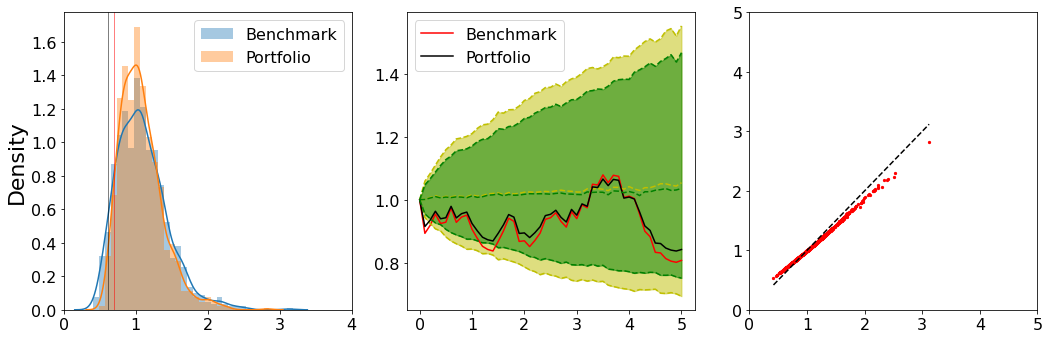

0.99163234 0.9929116

....................860 duaration =  1.432  secs
Wass Dist: 0.072 Risk Measure: -0.942 Loss: -0.942


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


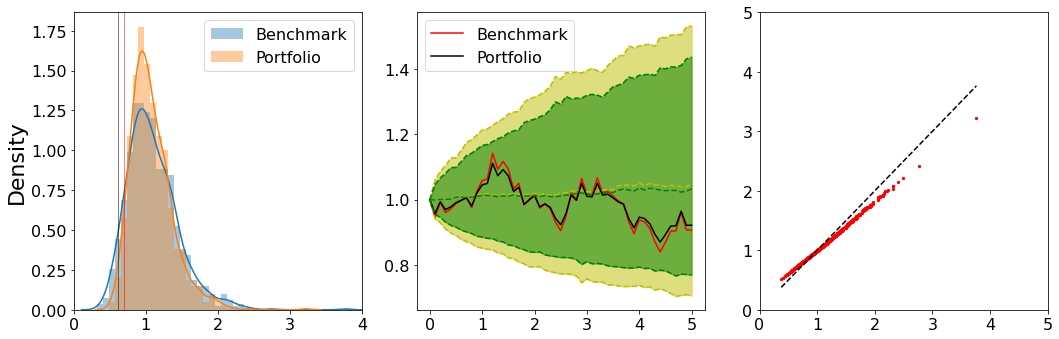

0.98824084 0.990849

....................880 duaration =  1.263  secs
Wass Dist: 0.077 Risk Measure: -0.955 Loss: -0.955


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


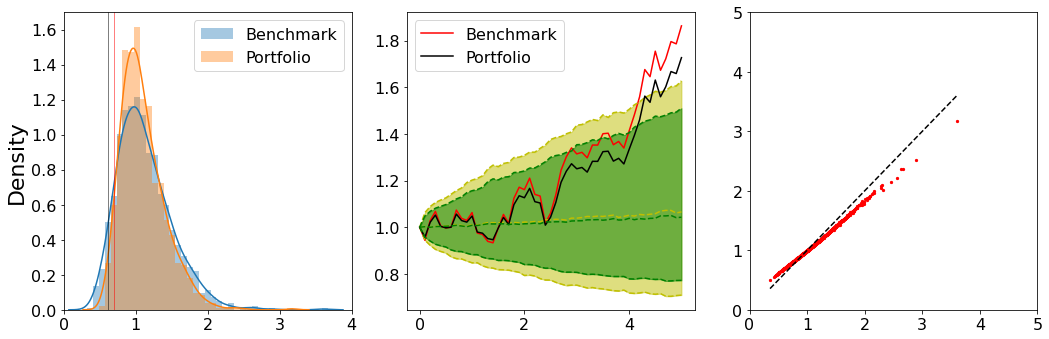

1.0042464 1.0031123

....................900 duaration =  1.250  secs
Wass Dist: 0.075 Risk Measure: -0.950 Loss: -0.950


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


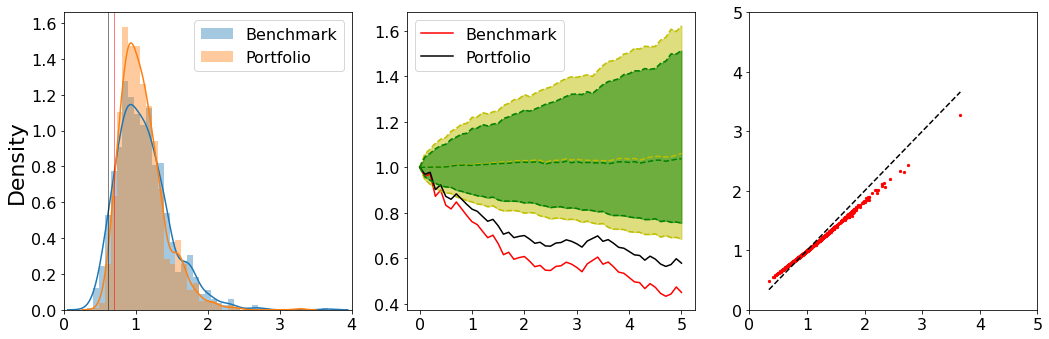

1.0013523 1.000224

....................920 duaration =  1.237  secs
Wass Dist: 0.074 Risk Measure: -0.972 Loss: -0.972


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


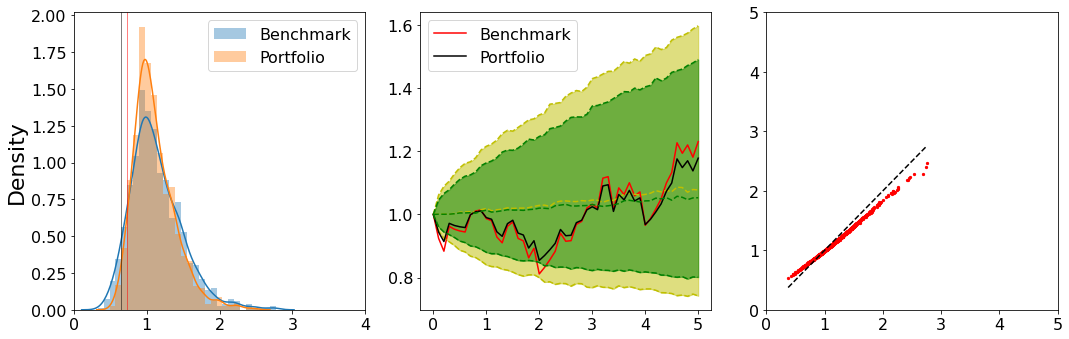

0.99537474 0.9957963

....................940 duaration =  1.436  secs
Wass Dist: 0.101 Risk Measure: -0.961 Loss: 9.164


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


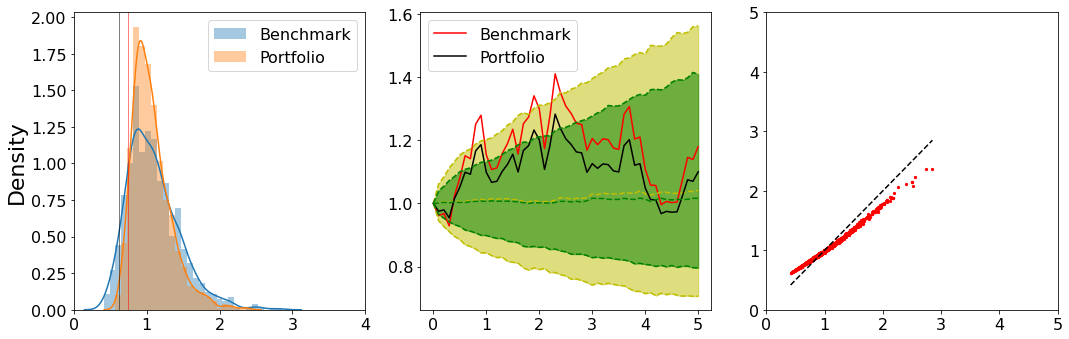

1.0019842 1.001596

....................960 duaration =  1.481  secs
Wass Dist: 0.040 Risk Measure: -0.964 Loss: -0.964


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


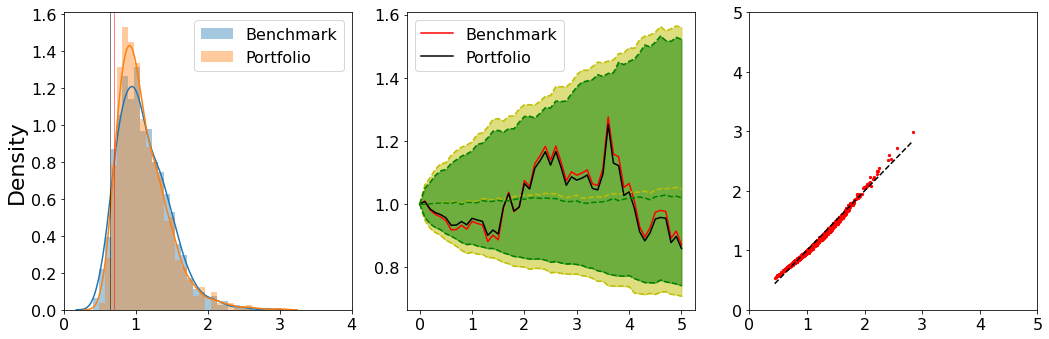

1.0087773 1.0077157

....................980 duaration =  1.312  secs
Wass Dist: 0.043 Risk Measure: -0.958 Loss: -0.958


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


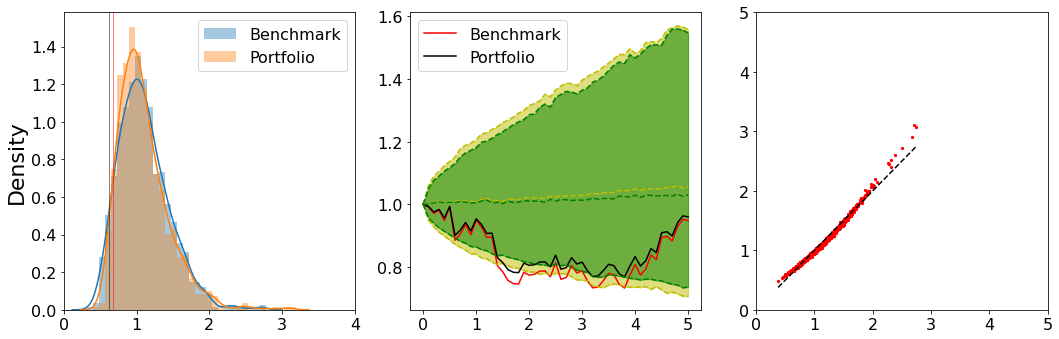

1.0032728 1.0035089

...................Finished Training


In [75]:
# train the model

optimizer = optim.Adam(net.parameters())


Nepochs =1000
loss_hist = []
risk_history = []
wass_dist_history=[]

start_time= time.time()

for epoch in range(Nepochs):  # loop over the dataset multiple times

    
    
    # zero the parameter gradients
    optimizer.zero_grad()


    #hedge_payoff, true_payoff, S = SimHedge(net, Ndt, S0, mu, sigma, T, Nsims, True)
    wt, RiskMeasure, wass_dist, PortfolioVal_T, IndexVal_T, t, IndexVal_path, PortfolioVal_path \
        = SimRM(net, Ndt=500, T=5, Nsims=1000, params=params, device=device)
    
    #loss = 100*(wass_dist)*(wass_dist>0.2) + RiskMeasure +100*(wass_dist)*(wass_dist>0.15)
    loss = 100*(wass_dist)*(wass_dist>0.1) + RiskMeasure 
    
    loss.backward()   
    
    # optimize
    optimizer.step()
    
    # store running loss
    loss_hist.append(  loss.item() )
    risk_history.append( RiskMeasure.cpu().detach().numpy() )
    wass_dist_history.append( wass_dist.cpu().detach().numpy() )
    
    print(".",end="")
    
    # plot output every 50 iterations
    if( (epoch % 20 == 0) and (epoch>1) ):
        
        print(epoch, end=" ")
        print("duaration = ", "{:.3f}".format(time.time() - start_time), " secs")
        start_time = time.time()
        
        print("Wass Dist:", "{:.3f}".format(wass_dist_history[-1]), end=" " )
        print("Risk Measure:", "{:.3f}".format(risk_history[-1]), end=" ")
        print("Loss:", "{:.3f}".format(loss.item()))

        PlotHists(IndexVal_T, PortfolioVal_T, t, IndexVal_path, PortfolioVal_path)
                
        
        _, _, _, PortfolioVal_T_Q, BenchmarkVal_T_Q, _, _, _ = SimRM(net, Ndt=500, T=5, Nsims=1000, params=params_Q, device=device)
        print(np.mean(np.exp(-params_Q["rf"]*5) * BenchmarkVal_T_Q.cpu().detach().numpy()), end=" ")
        print(np.mean(np.exp(-params_Q["rf"]*5) * PortfolioVal_T_Q.cpu().detach().numpy()), end="\n\n")        
        

print('Finished Training')

In [76]:
X_pi_T = np.zeros((0,1))
X_delta_T = np.zeros((0,1))
for i in range(10):
    _, _, _, PortfolioVal_T_Q, BenchmarkVal_T_Q, _, _, _ = SimRM(net, Ndt=500, T=5, Nsims=10000, params=params_Q, device=device)
    X_pi_T = np.concatenate((X_pi_T,PortfolioVal_T_Q.cpu().detach().numpy()))
    X_delta_T = np.concatenate((X_pi_T,BenchmarkVal_T_Q.cpu().detach().numpy()))
    
print(np.mean(np.exp(-params_Q["rf"]*5) * X_delta_T), end=" ")
print(np.mean(np.exp(-params_Q["rf"]*5) * X_pi_T), end="\n\n")  

1.0015774012947625 1.0012061447605491



In [77]:
X_delta_T.shape

(110000, 1)

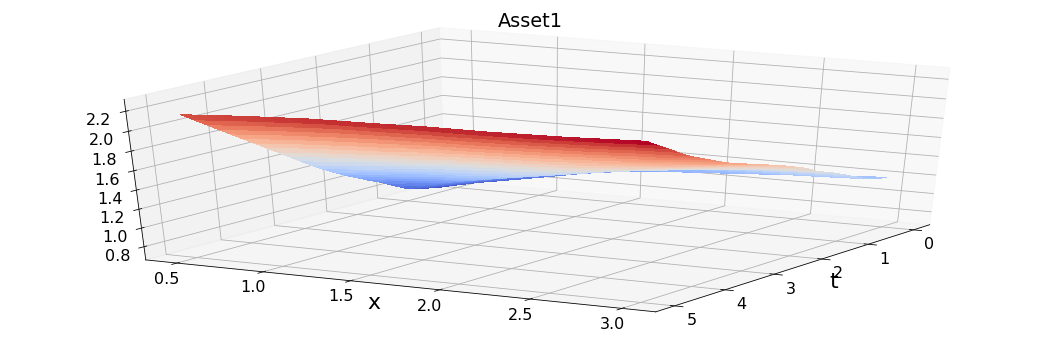

In [78]:
def PlotStrat(net, device):
    
    #t = np.linspace(0, 5, 100)
    X_delta_t = np.linspace(0.5, 3, 100)
     
    x1, x2 = np.meshgrid(t, X_delta_t)
    
    x = np.zeros((x1.shape[0], x1.shape[1], 2))
    
    x[:,:,0] = x1
    x[:,:,1] = x2
    
    x_t = torch.tensor(x, dtype=torch.float, device=device )
    
    w_t = net(x_t).cpu().detach().numpy()
        
    fig = plt.figure(figsize=(15,5))

    #params["delta"]
    
    for i in range(w_t.shape[2]):
            
        ax = fig.add_subplot(1, w_t.shape[2], i+1, projection='3d')
        #Normalizing the weights to get the ratio of portfolio and benchmark weight
        ax.plot_surface(x1, x2, w_t[:,:,i]/params["delta"][i], cmap=cm.coolwarm, linewidth=0, antialiased=False)
        
        ax.view_init(30, 30)
        
        plt.title('Asset' + str(i+1))
        
        plt.xlabel('t')
        plt.ylabel('x')
    
    plt.tight_layout()
    plt.show()
    
    
    # for i in range(0,x1.shape[1],5):
    
    #     fig = plt.figure(figsize=(10,5))
    
    #     plt.subplot(1,3,1)
    #     plt.plot(X_delta_t, w_t[:,i,0])
        
    #     plt.subplot(1,3,2)
    #     plt.plot(X_delta_t, w_t[:,i,1])

    #     plt.subplot(1,3,3)
    #     plt.plot(X_delta_t, w_t[:,i,1])
        
    #     plt.suptitle("t={0:0.2f}".format(t[i]) , fontsize= 20 )
    #     plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    #     plt.show()
    
    
PlotStrat(net, device)
    

### Backtesting

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate

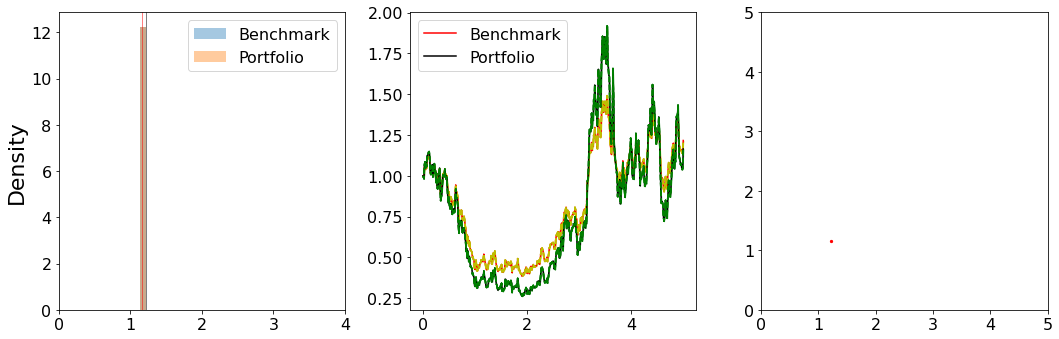

In [79]:
#backtesting_params = params

# backtesting_params = {
#     "S0" : np.array([1]),
#     "mu" : np.array([0.03]),
#     "sigma" : np.array([0.3]),
#     "rho" : np.array([[1]]),
#     "rf" : 0.01,
#     "delta" : np.array([0.7])
#     }

backtesting_params = {
    "S0" : np.array([1, 1]),
    "mu" : np.array([0.05, 0.05]),
    "sigma" : np.array([0.1, 0.8]),
    "rho" : np.array([[1, .25],[.25,1]]),
    "rf" : 0.01,
    "delta" : np.array([0.5, 0.5])
    }

# backtesting_params = {
#     "S0" : np.array([1, 2,3,1]),
#     "mu" : np.array([0.5, 0.06, .06, .06]),
#     "sigma" : np.array([.7, 0.30 , .10, .10]),
#     "rho" : np.array([[1, 0.25,.25, .25],[0.25,1,.25, .25], [0.25,.25,1, .25], [0.25,.25,.25,1]]),
#     "rf" : 0.01,
#     "delta" : np.array([0.2, 0.3, .3, .4 ])
#     }

wt, RiskMeasure, wass_dist, PortfolioVal_T, BenchmarkVal_T, \
    t, BenchmarkVal_path, PortfolioVal_path = SimRM(net, Ndt=500, T=5, Nsims=1, params=backtesting_params, device=device)
    
PlotHists(BenchmarkVal_T, PortfolioVal_T, t, BenchmarkVal_path, PortfolioVal_path)

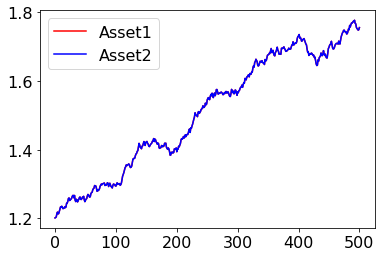

In [80]:
plt.plot(np.array(torch.mean(wt, 1).cpu().detach().numpy()/backtesting_params["delta"])[:,0], label='Asset1', color='r')
plt.plot(np.array(torch.mean(wt, 1).cpu().detach().numpy()/backtesting_params["delta"])[:,1], label='Asset2', color='b')
plt.legend()

In [81]:
wt

tensor([[[0.6007]],

        [[0.6013]],

        [[0.6023]],

        [[0.6068]],

        [[0.6092]],

        [[0.6065]],

        [[0.6071]],

        [[0.6105]],

        [[0.6134]],

        [[0.6167]],

        [[0.6161]],

        [[0.6177]],

        [[0.6165]],

        [[0.6142]],

        [[0.6146]],

        [[0.6150]],

        [[0.6170]],

        [[0.6156]],

        [[0.6167]],

        [[0.6220]],

        [[0.6223]],

        [[0.6250]],

        [[0.6290]],

        [[0.6298]],

        [[0.6261]],

        [[0.6268]],

        [[0.6281]],

        [[0.6288]],

        [[0.6314]],

        [[0.6333]],

        [[0.6335]],

        [[0.6300]],

        [[0.6334]],

        [[0.6266]],

        [[0.6245]],

        [[0.6279]],

        [[0.6270]],

        [[0.6240]],

        [[0.6263]],

        [[0.6276]],

        [[0.6303]],

        [[0.6313]],

        [[0.6279]],

        [[0.6275]],

        [[0.6288]],

        [[0.6309]],

        [[0.6304]],

        [[0.6

In [82]:
#%debug

In [83]:
import pickle 

In [84]:
pickle.dump( net, open( "net_Nov2.p", "wb" ) )